In [2]:
# Librerías Necesarias

# Preprocesamiento de Datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Métricas de Evaluación
from sklearn.metrics import mean_squared_error, r2_score

# Modelado con TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Guardado y Carga de Modelos
import joblib

# Visualización
import matplotlib.pyplot as plt

# Sistema Operativo
import os

In [3]:
# Rutas de Datos
ruta_train_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          15000 non-null  int64
 1   clip_count  15000 non-null  int64
dtypes: int64(2)
memory usage: 234.5 KB


In [5]:
df_train.describe()

,id,clip_count
count,15000.000000,15000.000000
mean,37500.500000,37.290133
std,4330.271354,21.922691
min,30001.000000,0.000000
25%,33750.750000,18.000000
50%,37500.500000,37.000000
75%,41250.250000,56.000000
max,45000.000000,75.000000


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [7]:
df_test.describe()

,id
count,5000.000000
mean,47500.500000
std,1443.520003
min,45001.000000
25%,46250.750000
50%,47500.500000
75%,48750.250000
max,50000.000000


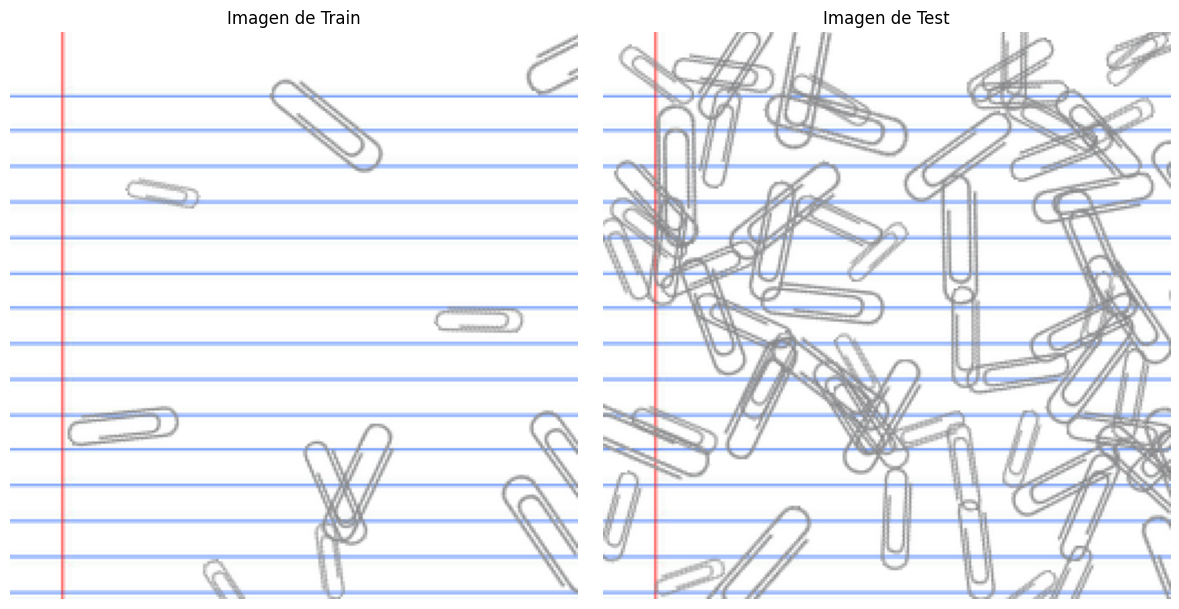

In [8]:
import cv2
import matplotlib.pyplot as plt
import os

# Función para mostrar una imagen
def mostrar_imagen(ruta_img, img_id, titulo):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(titulo)
    plt.axis('off')

# Visualizar imágenes de train y test
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Imagen de train
plt.subplot(1, 2, 1)
mostrar_imagen(ruta_train_img, img_id='30001', titulo='Imagen de Train')

# Imagen de test
plt.subplot(1, 2, 2)
mostrar_imagen(ruta_test_img, img_id='45001', titulo='Imagen de Test')

plt.tight_layout()
plt.show()


In [9]:
# Función para obtener información de una imagen
def obtener_info_imagen(ruta_img, img_id):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    
    # Tipo de archivo
    extension = os.path.splitext(img_path)[-1]
    
    # Dimensiones de la imagen
    altura, anchura = img.shape[:2]
    
    # Tipo de color
    if len(img.shape) == 3:
        canales = img.shape[2]
        tipo_color = "Color (RGB)" if canales == 3 else "Escala de Grises con Alfa"
    else:
        tipo_color = "Escala de Grises"
    
    # Mostrar resultados
    print(f"Información de la imagen: {img_path}")
    print(f"- Dimensiones: {anchura} x {altura}")
    print(f"- Tipo de archivo: {extension}")
    print(f"- Tipo de color: {tipo_color}")

# Mostrar información de una imagen de entrenamiento y una de prueba
print("Imagen de Entrenamiento:")
obtener_info_imagen(ruta_train_img, img_id='30001')

print("\nImagen de Prueba:")
obtener_info_imagen(ruta_test_img, img_id='45001')


Imagen de Entrenamiento:
Información de la imagen: D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)

Imagen de Prueba:
Información de la imagen: D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test\clips-45001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)


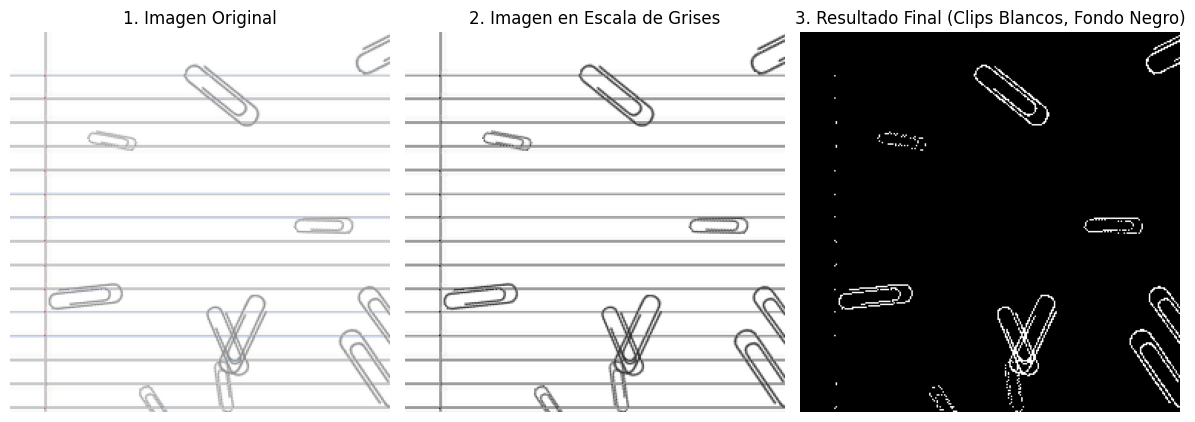

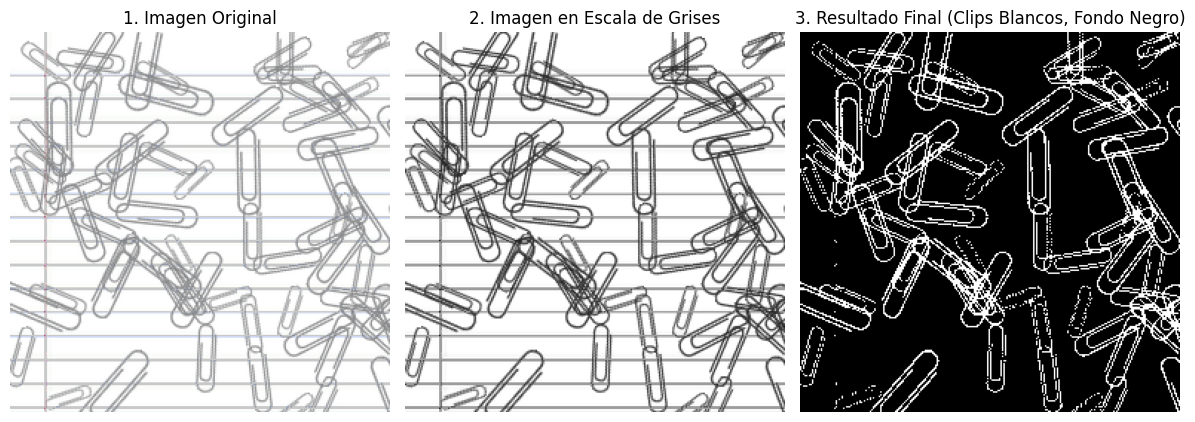

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# ✅ Función para simplificar el procesamiento
def simplificar_proceso(img_path):
    # Leer la imagen
    img = cv.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    
    # Convertir a espacio de color HSV para facilitar la manipulación de colores
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Crear máscaras para los colores azul y rojo
    mask_azul = cv.inRange(hsv, (100, 50, 50), (140, 255, 255))  # Rango para azul
    mask_rojo1 = cv.inRange(hsv, (0, 50, 50), (10, 255, 255))    # Rango para rojo (parte 1)
    mask_rojo2 = cv.inRange(hsv, (170, 50, 50), (180, 255, 255)) # Rango para rojo (parte 2)
    mask_rojo = cv.bitwise_or(mask_rojo1, mask_rojo2)
    
    # Fusionar las máscaras azul y roja
    mask_combined = cv.bitwise_or(mask_azul, mask_rojo)
    
    # Cambiar los colores detectados (azul y rojo) al color de los clips (gris claro)
    img[mask_combined > 0] = (200, 200, 200)  # Gris claro
    
    # Convertir la imagen a escala de grises
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Aplicar binarización
    _, thresh = cv.threshold(gray, 180, 255, cv.THRESH_BINARY)
    
    # Invertir para que los clips sean blancos y el fondo negro
    final_img = cv.bitwise_not(thresh)
    
    # Mostrar resultados
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.title('1. Imagen Original')
    plt.axis('off')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title('2. Imagen en Escala de Grises')
    plt.axis('off')
    plt.imshow(gray, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('3. Resultado Final (Clips Blancos, Fondo Negro)')
    plt.axis('off')
    plt.imshow(final_img, cmap='gray')
    
    plt.tight_layout()
    plt.show()

# ✅ Rutas de ejemplo
ruta_entrenamiento = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30001.png'
ruta_prueba = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test\clips-45001.png'

# ✅ Visualizar resultados simplificados
simplificar_proceso(ruta_entrenamiento)
simplificar_proceso(ruta_prueba)


In [12]:
import cv2 as cv
import numpy as np
import os
from tqdm import tqdm  # Barra de progreso para visualizar el proceso

# ✅ Función para preprocesar una imagen individual
def preprocesar_imagen(img_path):
    # Leer la imagen
    img = cv.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    
    # Convertir a HSV para manejar colores específicos
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    # Detectar colores azul y rojo
    mask_azul = cv.inRange(hsv, (100, 50, 50), (140, 255, 255))  # Azul
    mask_rojo1 = cv.inRange(hsv, (0, 50, 50), (10, 255, 255))    # Rojo (parte 1)
    mask_rojo2 = cv.inRange(hsv, (170, 50, 50), (180, 255, 255)) # Rojo (parte 2)
    mask_rojo = cv.bitwise_or(mask_rojo1, mask_rojo2)
    
    # Combinar las máscaras azul y rojo
    mask_combined = cv.bitwise_or(mask_azul, mask_rojo)
    
    # Reemplazar los colores detectados por gris claro
    img[mask_combined > 0] = (200, 200, 200)  # Gris claro
    
    # Convertir a escala de grises
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Binarizar la imagen
    _, thresh = cv.threshold(gray, 180, 255, cv.THRESH_BINARY)
    
    # Invertir para que los clips sean blancos sobre fondo negro
    final_img = cv.bitwise_not(thresh)
    
    return final_img


# ✅ Función para procesar todas las imágenes en una carpeta
def procesar_imagenes_en_carpeta(ruta_carpeta):
    imagenes_procesadas = []
    nombres_imagenes = []
    
    if not os.path.exists(ruta_carpeta):
        raise FileNotFoundError(f"La ruta no existe: {ruta_carpeta}")
    
    for archivo in tqdm(os.listdir(ruta_carpeta), desc=f"Procesando imágenes en {ruta_carpeta}"):
        ruta_completa = os.path.join(ruta_carpeta, archivo)
        if os.path.isfile(ruta_completa) and archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_procesada = preprocesar_imagen(ruta_completa)
            imagenes_procesadas.append(img_procesada)
            nombres_imagenes.append(archivo)
    
    return imagenes_procesadas, nombres_imagenes


# ✅ Rutas de las carpetas
ruta_train_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# ✅ Procesar las imágenes
imagenes_train, nombres_train = procesar_imagenes_en_carpeta(ruta_train_img)
imagenes_test, nombres_test = procesar_imagenes_en_carpeta(ruta_test_img)

print(f"\n✅ {len(imagenes_train)} imágenes procesadas en TRAIN.")
print(f"✅ {len(imagenes_test)} imágenes procesadas en TEST.")



Procesando imágenes en D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train: 100%|██████████| 15000/15000 [02:21<00:00, 106.25it/s]
Procesando imágenes en D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test: 100%|██████████| 5000/5000 [00:45<00:00, 110.08it/s]


✅ 15000 imágenes procesadas en TRAIN.
✅ 5000 imágenes procesadas en TEST.


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# ✅ Normalización de imágenes
X_imagenes_train = np.array(imagenes_train, dtype=np.float32) / 255.0
X_imagenes_test = np.array(imagenes_test, dtype=np.float32) / 255.0

# ✅ Añadir canal extra (1 para escala de grises)
X_imagenes_train = X_imagenes_train[..., np.newaxis]
X_imagenes_test = X_imagenes_test[..., np.newaxis]

# ✅ Extraer etiquetas desde el CSV
y_etiquetas_train = df_train['clip_count'].values

# ✅ Dividir en Train y Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_imagenes_train, y_etiquetas_train, test_size=0.2, random_state=42
)

# ✅ Verificar las formas de los datos
print(f"✅ Train: {X_train.shape}, Etiquetas: {y_train.shape}")
print(f"✅ Validation: {X_val.shape}, Etiquetas: {y_val.shape}")
print(f"✅ Test: {X_imagenes_test.shape}")


✅ Train: (12000, 256, 256, 1), Etiquetas: (12000,)
✅ Validation: (3000, 256, 256, 1), Etiquetas: (3000,)
✅ Test: (5000, 256, 256, 1)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError

# ✅ Modelo CNN con RMSE como métrica
modelo_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(1)  # Salida numérica para el recuento de clips
])

# ✅ Compilar el modelo
modelo_cnn.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[RootMeanSquaredError(name='rmse')]
)

# ✅ Mostrar resumen del modelo
modelo_cnn.summary()


c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,509,505 (120.20 MB)

 Trainable params: 31,509,313 (120.20 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ✅ Callbacks para optimizar el entrenamiento
callback_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callback_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

callback_checkpoint = ModelCheckpoint(
    'modelo_mejor.keras',  # ✅ Cambiar extensión a `.keras`
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)



In [16]:
import tensorflow as tf

# Parámetros Globales
IMG_SIZE = (256, 256)
BATCH_SIZE = 16  # Reducido para optimizar memoria
AUTOTUNE = tf.data.AUTOTUNE

# ✅ Función para Preprocesar una Imagen
def cargar_y_preprocesar_imagen(img_path, label=None):
    # Leer la imagen
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalizar entre 0 y 1
    
    if label is not None:
        return img, tf.cast(label, tf.float32)
    return img

# ✅ Crear Dataset para Entrenamiento y Validación
train_dataset = tf.data.Dataset.from_tensor_slices((df_train['id'].values, df_train['clip_count'].values))
train_dataset = train_dataset.map(lambda id, label: cargar_y_preprocesar_imagen(
    tf.strings.join([ruta_train_img, "/clips-", tf.strings.as_string(id), ".png"]), label),
    num_parallel_calls=AUTOTUNE
).shuffle(buffer_size=500).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_val['id'].values, df_val['clip_count'].values))
val_dataset = val_dataset.map(lambda id, label: cargar_y_preprocesar_imagen(
    tf.strings.join([ruta_train_img, "/clips-", tf.strings.as_string(id), ".png"]), label),
    num_parallel_calls=AUTOTUNE
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ✅ Entrenar el Modelo con el Dataset Optimizado
historial_cnn = modelo_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[callback_early_stopping, callback_reduce_lr, callback_checkpoint]
)



NameError: name 'df_val' is not defined

In [ ]:
# ✅ Evaluar el modelo en el conjunto de validación
resultado_val = modelo_cnn.evaluate(X_val, y_val)
print(f"✅ Pérdida en validación: {resultado_val[0]:.4f}")
print(f"✅ RMSE en validación: {resultado_val[1]:.4f}")

# ✅ Predecir los valores en el conjunto de prueba
predicciones_test = modelo_cnn.predict(X_imagenes_test)

# ✅ Crear un DataFrame con los resultados
df_resultados_test = df_test.copy()
df_resultados_test['clip_count'] = predicciones_test.flatten().astype(int)

# ✅ Guardar los resultados en un archivo CSV
df_resultados_test.to_csv('resultados_test.csv', index=False)

print("✅ Predicciones guardadas en 'resultados_test.csv'")


In [ ]:
import matplotlib.pyplot as plt

# ✅ Gráficas de entrenamiento
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(historial_cnn.history['loss'], label='Pérdida Entrenamiento')
plt.plot(historial_cnn.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Evolución de la Pérdida')
plt.legend()

# RMSE
plt.subplot(1, 2, 2)
plt.plot(historial_cnn.history['rmse'], label='RMSE Entrenamiento')
plt.plot(historial_cnn.history['val_rmse'], label='RMSE Validación')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.title('Evolución del RMSE')
plt.legend()

plt.tight_layout()
plt.show()
